# 1. IMPORT BIBLIOTHEQUES ET RECUPERATION ET AJUSTEMENT DU DATASET CONSOLIDE

In [107]:
#Import des bibliothèques
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns  
import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

#IMPORT FICHIER
df=pd.read_csv("../../DataSet/COMPILATION_CONSO_TEMP_POP_2.csv" , sep = ';' )

# Suppression des colonnes inutiles = PREDICTION SUR TEMPERATURE MOYENNE
df = df.drop(columns=['TMin (°C)', 'TMax (°C)', 'POP (en milliers)','Date - Heure'])

# Filtrer les données temporelles pour se concentrer sur une période pertinente et enlever la Corse
df_filtered = df[(df['Date + Heure'] >= '2016-01-01') & 
                 (df['Date + Heure'] <= '2024-12-31')& (df['Région']!='Corse')] 

# Identifier les lignes avec -0.00 dans les colonnes spécifiques
cols_to_check = ['TMoy (°C)']
neg_zero_mask = (df_filtered[cols_to_check] == -0.00)

# Appliquer la correction uniquement aux valeurs identifiées en utilisant .loc
df_filtered.loc[:, cols_to_check] = df_filtered.loc[:, cols_to_check].mask(neg_zero_mask, 0.00)

# Remettre la colonne 'Date + Heure' en index
df = df_filtered.set_index('Date + Heure')
df.index = pd.to_datetime(df.index)

# Grouper par 'Région' et appliquer le resampling par semaine (lundi au dimanche)
df_resampled = df.groupby('Région').resample('D', label='left').agg({
    'Date' : 'first',
    'Consommation (MW)':'mean',  # Moyenne de la consommation par semaine
    'TMoy (°C)': 'mean',          # Moyenne de la température moyenne par semaine
    'Année': 'first',             # Première année dans chaque semaine

}).reset_index()

df=df_resampled

# Conversion en datetime DATE pour extractions 
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')


# Extraire les caractéristiques temporelles SUPPLEMENTAIRES à partir de 'DATE'
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek  # Lundi = 0, Dimanche = 6
df['day_of_year'] = df['Date'].dt.dayofyear
df['week_of_year'] = df['Date'].dt.isocalendar().week
#df['PlageHoraire']= df['Heure'].str[:2].astype(int) # Extraction de l'heure


#LastDrop
df = df.drop(columns=['Date']) 

# Vérifier le résultat
print(df.index.dtype)
display(df.info())

# Remettre la colonne 'Date + Heure' en index
df = df.set_index('Date + Heure')
df.index = pd.to_datetime(df.index)

display(df.info())


int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38930 entries, 0 to 38929
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Région             38930 non-null  object        
 1   Date + Heure       38930 non-null  datetime64[ns]
 2   Consommation (MW)  38930 non-null  float64       
 3   TMoy (°C)          38930 non-null  float64       
 4   Année              38930 non-null  int64         
 5   month              38930 non-null  int32         
 6   day_of_week        38930 non-null  int32         
 7   day_of_year        38930 non-null  int32         
 8   week_of_year       38930 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(2), int32(3), int64(1), object(1)
memory usage: 2.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38930 entries, 2016-01-01 to 2024-12-30
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Région             38930 non-null  object 
 1   Consommation (MW)  38930 non-null  float64
 2   TMoy (°C)          38930 non-null  float64
 3   Année              38930 non-null  int64  
 4   month              38930 non-null  int32  
 5   day_of_week        38930 non-null  int32  
 6   day_of_year        38930 non-null  int32  
 7   week_of_year       38930 non-null  UInt32 
dtypes: UInt32(1), float64(2), int32(3), int64(1), object(1)
memory usage: 2.1+ MB


None

In [108]:

# Récupérer toutes les colonnes du DataFrame
all_columns = df.columns.tolist()

# Définir la target (à exclure des features)
target = 'Consommation (MW)'

# Définir une liste de colonnes à exclure (en plus de la target)
exclude_columns = ['Région']

# Sélectionner les features en excluant la target et les colonnes à exclure
features = [col for col in all_columns if col != target and col not in exclude_columns]

# Afficher les features et la target
print(f"Features: {features}")
print(f"Target: {target}")
df

## 2.3 HOLD OUT - SPLIT DATE (Train DATASET)
# Définir la proportion de l'ensemble de test
test_size = 0.20  # Pour 20%

# Calculer la date de séparation
split_date = df.iloc[int(len(df) * (1 - test_size))].name

Features: ['TMoy (°C)', 'Année', 'month', 'day_of_week', 'day_of_year', 'week_of_year']
Target: Consommation (MW)


In [109]:
df

,Région,Consommation (MW),TMoy (°C),Année,month,day_of_week,day_of_year,week_of_year
Date + Heure,,,,,,,,
2016-01-01,Auvergne-Rhône-Alpes,7569.750000,6.760000,2015,1,4,1,53
2016-01-02,Auvergne-Rhône-Alpes,7818.437500,7.200000,2016,1,5,2,53
2016-01-03,Auvergne-Rhône-Alpes,7989.250000,5.080000,2016,1,6,3,53
2016-01-04,Auvergne-Rhône-Alpes,9082.500000,7.170000,2016,1,0,4,1
2016-01-05,Auvergne-Rhône-Alpes,9322.250000,7.010000,2016,1,1,5,1
...,...,...,...,...,...,...,...,...
2024-12-26,Île-de-France,8539.281250,6.620000,2024,12,3,361,52
2024-12-27,Île-de-France,9476.739583,3.210000,2024,12,4,362,52
2024-12-28,Île-de-France,9839.927083,-0.280000,2024,12,5,363,52


# 2. ML - XG Boost & Random - EVALUATION


In [110]:
results = []

# Listes pour stocker les prédictions et les vraies valeurs
all_y_test_XGB = []
all_y_pred_XGB = []

# Itérer sur chaque région
for region in df['Région'].unique():
    print(f"Analyse pour la région: {region}")
    
    # Filtrer les données pour la région actuelle
    df_region = df[df['Région'] == region]
    
    # Préparation des données
    X = df_region[features]
    y = df_region[target]
    
    # Séparation des données en ensembles d'entraînement et de test
    X_train = X[df_region.index < split_date]
    X_test = X[df_region.index >= split_date]
    y_train = y[df_region.index < split_date]
    y_test = y[df_region.index >= split_date]
    
    # Création et entraînement du modèle XGBoost
    model = XGBRegressor(n_estimators=300, learning_rate=0.5, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Ajouter les prédictions et les vraies valeurs aux listes globales
    all_y_test_XGB.extend(y_test)
    all_y_pred_XGB.extend(y_pred)
    
    # Évaluation du modèle
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Correction du MAPE
    r2 = r2_score(y_test, y_pred)
    
    # Moyennes des valeurs réelles et prédites
    mean_y_test = np.mean(y_test)
    mean_y_pred = np.mean(y_pred)

    # Calcul du Bias
    bias = mean_y_pred - mean_y_test

    # Stocker les résultats
    result = {
        'Région': region,
        'Moy y_test': mean_y_test,
        'Moy y_pred': mean_y_pred,
        'Bias': bias,  # Ajout du Bias
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'R^2 Score': r2
    }
    
    # Ajouter les importances des features au dictionnaire de résultats
    for feature, importance in zip(X.columns, model.feature_importances_):
        result[f'Importance {feature}'] = importance
    
    results.append(result)

# Affichage des résultats pour toutes les régions
results_df = pd.DataFrame(results)
display(results_df)

# Calculer la moyenne de chaque métrique
mean_metrics = results_df[['R^2 Score', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'Mean Absolute Percentage Error', 'Bias']].mean()

# Afficher les résultats globaux
print(f"Moyenne des métriques d'évaluation :")
for metric, value in mean_metrics.items():
    print(f"{metric}: {value:.4f}")


Analyse pour la région: Auvergne-Rhône-Alpes
Analyse pour la région: Bourgogne-Franche-Comté
Analyse pour la région: Bretagne
Analyse pour la région: Centre-Val de Loire
Analyse pour la région: Grand Est
Analyse pour la région: Hauts-de-France
Analyse pour la région: Normandie
Analyse pour la région: Nouvelle-Aquitaine
Analyse pour la région: Occitanie
Analyse pour la région: Pays de la Loire
Analyse pour la région: Provence-Alpes-Côte d'Azur
Analyse pour la région: Île-de-France


,Région,Moy y_test,Moy y_pred,Bias,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,R^2 Score,Importance TMoy (°C),Importance Année,Importance month,Importance day_of_week,Importance day_of_year,Importance week_of_year
0,Auvergne-Rhône-Alpes,7049.234967,7250.977051,201.742084,285502.202149,534.324061,426.858076,6.146412,0.849103,0.556214,0.052247,0.038344,0.210621,0.054707,0.087866
1,Bourgogne-Franche-Comté,2291.473717,2422.214844,130.741127,45293.767077,212.823324,169.156330,7.915887,0.814172,0.477456,0.032080,0.029095,0.276526,0.057586,0.127257
2,Bretagne,2360.772737,2581.531006,220.758269,92660.962772,304.402633,242.806631,10.511396,0.678009,0.549143,0.012110,0.012923,0.200525,0.064818,0.160481
3,Centre-Val de Loire,1947.171340,2082.001465,134.830125,51851.043345,227.708242,179.297491,9.725531,0.762918,0.557672,0.020088,0.053166,0.132969,0.044721,0.191383
4,Grand Est,4765.466703,5156.418945,390.952242,290332.588205,538.825193,442.090869,9.656069,0.620022,0.407716,0.030878,0.142436,0.255625,0.045342,0.118003
5,Hauts-de-France,5412.685120,5560.479004,147.793884,173534.837722,416.575129,328.177502,6.081856,0.752828,0.478925,0.035948,0.147696,0.156216,0.045692,0.135523
6,Normandie,2911.457163,3116.442383,204.985219,111034.615247,333.218570,256.699488,9.132235,0.707159,0.622749,0.021366,0.024684,0.119225,0.067770,0.144205
7,Nouvelle-Aquitaine,4626.872559,4921.791992,294.919433,345673.146065,587.939747,455.173252,10.470591,0.697677,0.603003,0.013179,0.015130,0.151355,0.053229,0.164104
8,Occitanie,4258.228915,4287.913574,29.684659,100828.716714,317.535379,236.790594,5.620178,0.866665,0.680646,0.017888,0.014504,0.116445,0.059164,0.111354
9,Pays de la Loire,2930.144745,3038.549805,108.405060,166052.558925,407.495471,264.792070,10.175102,0.679157,0.483509,0.014055,0.022653,0.238585,0.058278,0.182920


Moyenne des métriques d'évaluation :
R^2 Score: 0.7499
Mean Squared Error: 176117.8475
Root Mean Squared Error: 402.2677
Mean Absolute Error: 310.7473
Mean Absolute Percentage Error: 8.2354
Bias: 196.3447


In [129]:
results = []

# Listes pour stocker les prédictions et les vraies valeurs
all_y_test_RF = []
all_y_pred_RF = []

# Itérer sur chaque région
for region in df['Région'].unique():
    print(f"Analyse pour la région: {region}")
    
    # Filtrer les données pour la région actuelle
    df_region = df[df['Région'] == region]
    
    # Préparation des données
    X = df_region[features]
    y = df_region[target]
    
    # Séparation des données en ensembles d'entraînement et de test
    X_train = X[df_region.index < split_date]
    X_test = X[df_region.index >= split_date]
    y_train = y[df_region.index < split_date]
    y_test = y[df_region.index >= split_date]
    
    # Création et entraînement du modèle Random Forest
    model = RandomForestRegressor (
        n_estimators=10, 
        max_depth=10, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Ajouter les prédictions et les vraies valeurs aux listes globales
    all_y_test_RF.extend(y_test)
    all_y_pred_RF.extend(y_pred)
    
    # Évaluation du modèle
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Correction du MAPE
    r2 = r2_score(y_test, y_pred)
    
    # Moyennes des valeurs réelles et prédites
    mean_y_test = np.mean(y_test)
    mean_y_pred = np.mean(y_pred)

    # Calcul du Bias
    bias = mean_y_pred - mean_y_test

    # Stocker les résultats
    result = {
        'Région': region,
        'Moy y_test': mean_y_test,
        'Moy y_pred': mean_y_pred,
        'Bias': bias,  # Ajout du Bias
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'R^2 Score': r2
    }
    
    # Ajouter les importances des features au dictionnaire de résultats
    for feature, importance in zip(X.columns, model.feature_importances_):
        result[f'Importance {feature}'] = importance
    
    results.append(result)

# Affichage des résultats pour toutes les régions
results_df = pd.DataFrame(results)
display(results_df)

# Calculer la moyenne de chaque métrique
mean_metrics = results_df[['R^2 Score', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'Mean Absolute Percentage Error', 'Bias']].mean()

# Afficher les résultats globaux
print(f"Moyenne des métriques d'évaluation :")
for metric, value in mean_metrics.items():
    print(f"{metric}: {value:.4f}")


Analyse pour la région: Auvergne-Rhône-Alpes
Analyse pour la région: Bourgogne-Franche-Comté
Analyse pour la région: Bretagne
Analyse pour la région: Centre-Val de Loire
Analyse pour la région: Grand Est
Analyse pour la région: Hauts-de-France
Analyse pour la région: Normandie
Analyse pour la région: Nouvelle-Aquitaine
Analyse pour la région: Occitanie
Analyse pour la région: Pays de la Loire
Analyse pour la région: Provence-Alpes-Côte d'Azur
Analyse pour la région: Île-de-France


,Région,Moy y_test,Moy y_pred,Bias,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,R^2 Score,Importance TMoy (°C),Importance Année,Importance month,Importance day_of_week,Importance day_of_year,Importance week_of_year
0,Auvergne-Rhône-Alpes,7049.234967,7257.592607,208.357640,274168.040372,523.610581,412.068064,5.961623,0.855094,0.782934,0.028265,0.004799,0.082074,0.075884,0.026043
1,Bourgogne-Franche-Comté,2291.473717,2405.050641,113.576924,42796.610523,206.873417,163.881495,7.561954,0.824417,0.756268,0.017657,0.002183,0.119353,0.077008,0.027530
2,Bretagne,2360.772737,2560.531205,199.758468,78908.470832,280.906516,220.539995,9.504168,0.725798,0.774019,0.006745,0.004152,0.087209,0.077181,0.050694
3,Centre-Val de Loire,1947.171340,2080.564564,133.393224,47869.771423,218.791616,175.484412,9.382316,0.781122,0.826806,0.009669,0.001968,0.051156,0.071595,0.038806
4,Grand Est,4765.466703,5076.714504,311.247800,230284.666609,479.879846,389.720464,8.527911,0.698611,0.730981,0.024221,0.004582,0.119426,0.088209,0.032581
5,Hauts-de-France,5412.685120,5558.218855,145.533734,181466.343292,425.988666,331.508138,6.134270,0.741530,0.765144,0.025708,0.001723,0.072852,0.097185,0.037388
6,Normandie,2911.457163,3095.347655,183.890492,97697.742904,312.566382,234.993450,8.378728,0.742333,0.843518,0.012158,0.001545,0.048089,0.076825,0.017864
7,Nouvelle-Aquitaine,4626.872559,4904.838665,277.966106,299654.604567,547.407165,421.456828,9.723140,0.737925,0.849089,0.006910,0.003297,0.054233,0.057589,0.028882
8,Occitanie,4258.228915,4275.212679,16.983763,84974.320232,291.503551,222.296407,5.270186,0.887631,0.873135,0.009231,0.002126,0.041829,0.052642,0.021038
9,Pays de la Loire,2930.144745,3040.001679,109.856934,171049.000963,413.580707,264.682820,10.131729,0.669503,0.785716,0.008254,0.002661,0.106021,0.072862,0.024486


Moyenne des métriques d'évaluation :
R^2 Score: 0.7780
Mean Squared Error: 157345.9292
Root Mean Squared Error: 380.2948
Mean Absolute Error: 291.0895
Mean Absolute Percentage Error: 7.6956
Bias: 172.6848


# 3. ENTRAINEMENT ET EXPORT DES MODELES

ENTRAINEMENT SUR TOUT LE DATASET POUR PREDICTION DONNES FUTURES

In [144]:
import joblib

# Itérer sur chaque région
for region in df['Région'].unique():
    print(f"Entraînement du modèle pour la région : {region}")
    
    # Filtrer les données pour la région actuelle
    df_region = df[df['Région'] == region]
    
    # Préparation des données
    X = df_region[features]
    y = df_region[target]
    
    # Création et entraînement du modèle XGBoost
    model = XGBRegressor(n_estimators=300, learning_rate=0.5, max_depth=3, random_state=42)
    model.fit(X, y)
    
    # Sauvegarde du modèle avec joblib
    model_filename = f"XGB_{region}.joblib"
    joblib.dump(model, model_filename)
    
    # Confirmation de l'export
    print(f"Modèle sauvegardé : {model_filename}\n")


Entraînement du modèle pour la région : Auvergne-Rhône-Alpes
Modèle sauvegardé : XGB_Auvergne-Rhône-Alpes.joblib

Entraînement du modèle pour la région : Bourgogne-Franche-Comté
Modèle sauvegardé : XGB_Bourgogne-Franche-Comté.joblib

Entraînement du modèle pour la région : Bretagne
Modèle sauvegardé : XGB_Bretagne.joblib

Entraînement du modèle pour la région : Centre-Val de Loire
Modèle sauvegardé : XGB_Centre-Val de Loire.joblib

Entraînement du modèle pour la région : Grand Est
Modèle sauvegardé : XGB_Grand Est.joblib

Entraînement du modèle pour la région : Hauts-de-France
Modèle sauvegardé : XGB_Hauts-de-France.joblib

Entraînement du modèle pour la région : Normandie
Modèle sauvegardé : XGB_Normandie.joblib

Entraînement du modèle pour la région : Nouvelle-Aquitaine
Modèle sauvegardé : XGB_Nouvelle-Aquitaine.joblib

Entraînement du modèle pour la région : Occitanie
Modèle sauvegardé : XGB_Occitanie.joblib

Entraînement du modèle pour la région : Pays de la Loire
Modèle sauvegardé

In [131]:
import joblib

# Itérer sur chaque région
for region in df['Région'].unique():
    print(f"Entraînement du modèle pour la région : {region}")
    
    # Filtrer les données pour la région actuelle
    df_region = df[df['Région'] == region]
    
    # Préparation des données
    X = df_region[features]
    y = df_region[target]
    
    # Création et entraînement du modèle XGBoost sur 100% des données
    model = RandomForestRegressor(
        n_estimators=10, 
        max_depth=10, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        random_state=42
    )
    model.fit(X, y)
    
    # Sauvegarde du modèle avec joblib
    model_filename = f"RF_{region}.joblib"
    joblib.dump(model, model_filename)
    
    # Confirmation de l'export
    print(f"Modèle sauvegardé : {model_filename}\n")


Entraînement du modèle pour la région : Auvergne-Rhône-Alpes
Modèle sauvegardé : RF_Auvergne-Rhône-Alpes.joblib

Entraînement du modèle pour la région : Bourgogne-Franche-Comté
Modèle sauvegardé : RF_Bourgogne-Franche-Comté.joblib

Entraînement du modèle pour la région : Bretagne
Modèle sauvegardé : RF_Bretagne.joblib

Entraînement du modèle pour la région : Centre-Val de Loire
Modèle sauvegardé : RF_Centre-Val de Loire.joblib

Entraînement du modèle pour la région : Grand Est
Modèle sauvegardé : RF_Grand Est.joblib

Entraînement du modèle pour la région : Hauts-de-France
Modèle sauvegardé : RF_Hauts-de-France.joblib

Entraînement du modèle pour la région : Normandie
Modèle sauvegardé : RF_Normandie.joblib

Entraînement du modèle pour la région : Nouvelle-Aquitaine
Modèle sauvegardé : RF_Nouvelle-Aquitaine.joblib

Entraînement du modèle pour la région : Occitanie
Modèle sauvegardé : RF_Occitanie.joblib

Entraînement du modèle pour la région : Pays de la Loire
Modèle sauvegardé : RF_Pay

In [132]:
df_region

,Région,Consommation (MW),TMoy (°C),Année,month,day_of_week,day_of_year,week_of_year
Date + Heure,,,,,,,,
2016-01-01,Île-de-France,8316.333333,6.030000,2015,1,4,1,53
2016-01-02,Île-de-France,8419.833333,8.730000,2016,1,5,2,53
2016-01-03,Île-de-France,8769.437500,6.690000,2016,1,6,3,53
2016-01-04,Île-de-France,9979.520833,7.610000,2016,1,0,4,1
2016-01-05,Île-de-France,10409.666667,7.060000,2016,1,1,5,1
...,...,...,...,...,...,...,...,...
2024-12-26,Île-de-France,8539.281250,6.620000,2024,12,3,361,52
2024-12-27,Île-de-France,9476.739583,3.210000,2024,12,4,362,52
2024-12-28,Île-de-France,9839.927083,-0.280000,2024,12,5,363,52


# 4. PREDICTION

In [146]:
# Importation du fichier
df_future_temp = pd.read_csv("../dataset_streamlit/Future_temp.csv", index_col = 0)

# Conversion de la colonne 'time' en datetime
df_future_temp['time'] = pd.to_datetime(df_future_temp['time'])

# Renommage des colonnes
df_future_temp.rename(columns={'time': 'Date', 'region': 'Région', 'C°': 'TMoy (°C)'}, inplace=True)
df_future_temp

# Ajout des colonnes temporelles depuis l'index
df_future_temp['Année'] = df_future_temp['Date'].dt.year
df_future_temp['month'] = df_future_temp['Date'].dt.month
df_future_temp['day_of_week'] = df_future_temp['Date'].dt.dayofweek
df_future_temp['day_of_year'] = df_future_temp['Date'].dt.dayofyear
df_future_temp['week_of_year'] = df_future_temp['Date'].dt.isocalendar().week

df_future_temp = df_future_temp.set_index('Date')

# Réorganiser les colonnes (si nécessaire)
df_future_temp = df_future_temp[['Région', 'TMoy (°C)', 'Année', 'month', 'day_of_week', 'day_of_year', 'week_of_year']]
df_future_temp

,Région,TMoy (°C),Année,month,day_of_week,day_of_year,week_of_year
Date,,,,,,,
2024-01-01,Auvergne-Rhône-Alpes,-6.481888,2024,1,0,1,1
2024-01-01,Bourgogne-Franche-Comté,-5.388495,2024,1,0,1,1
2024-01-01,Bretagne,-0.088237,2024,1,0,1,1
2024-01-01,Centre-Val de Loire,-4.922131,2024,1,0,1,1
2024-01-01,Grand Est,-6.026100,2024,1,0,1,1
...,...,...,...,...,...,...,...
2035-12-31,Nouvelle-Aquitaine,6.032554,2035,12,0,365,1
2035-12-31,Occitanie,4.313919,2035,12,0,365,1
2035-12-31,Pays de la Loire,6.391923,2035,12,0,365,1


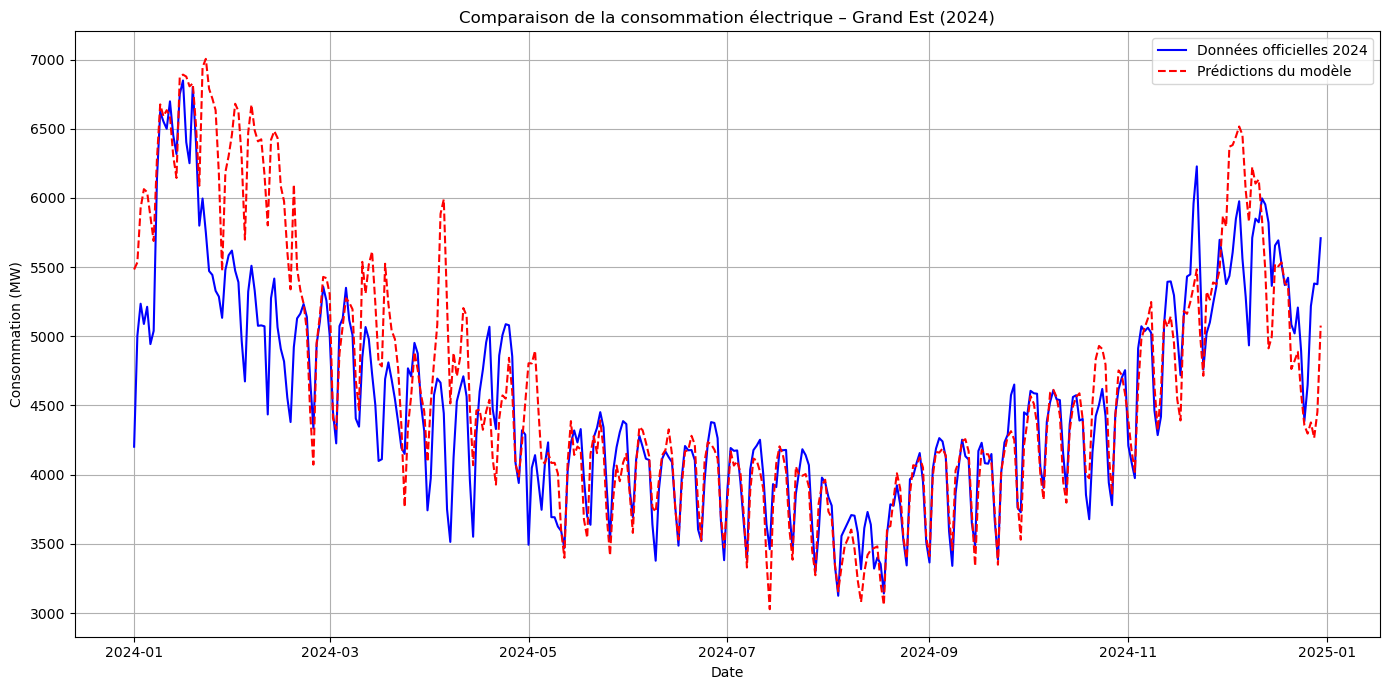

In [143]:

# --- 🔧 Paramètres ---
region = "Grand Est"
model_path = f"XGB_{region}.joblib"
features = ['TMoy (°C)', 'Année', 'month', 'day_of_week', 'day_of_year', 'week_of_year']

# --- 📦 Chargement du modèle ---
model = joblib.load(model_path)

# --- 📊 Données officielles 2024 ---
df_official = df[(df.index.year == 2024) & (df['Région'] == region)].copy()

# --- 🔮 Données pour la prédiction ---
df_region = df_future_temp[(df_future_temp["Région"] == region) & (df_future_temp.index.year == 2024)].copy()

# --- 🧠 Prédiction ---
X = df_region[features]
y_pred = model.predict(X)
df_region["Consommation prédite (MW)"] = y_pred

# --- 🔗 Fusion des deux DataFrames sur la date ---
df_comparison = pd.merge(
    df_official[['Consommation (MW)']],
    df_region[['Consommation prédite (MW)']],
    left_index=True,
    right_index=True
)

# --- 📈 Affichage ---
plt.figure(figsize=(14, 7))
plt.plot(df_comparison.index, df_comparison['Consommation (MW)'], label='Données officielles 2024', color='blue')
plt.plot(df_comparison.index, df_comparison['Consommation prédite (MW)'], label='Prédictions du modèle', color='red', linestyle='--')

plt.title(f'Comparaison de la consommation électrique – {region} (2024)')
plt.xlabel('Date')
plt.ylabel('Consommation (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
